### Fedavg

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install -U flwr["simulation"]

In [ ]:
import torch.nn as nn
import numpy as np
import pandas as pd


def _bin_age(age_series):
    bins = [-np.inf, 10, 40, np.inf]
    labels = ["Child", "Adult", "Elderly"]
    return (
        pd.cut(age_series, bins=bins, labels=labels, right=True)
        .astype(str)
        .replace("nan", "Unknown")
    )


def _extract_title(name_series):
    titles = name_series.str.extract(" ([A-Za-z]+)\.", expand=False)
    rare_titles = {
        "Lady",
        "Countess",
        "Capt",
        "Col",
        "Don",
        "Dr",
        "Major",
        "Rev",
        "Sir",
        "Jonkheer",
        "Dona",
    }
    titles = titles.replace(list(rare_titles), "Rare")
    titles = titles.replace({"Mlle": "Miss", "Ms": "Miss", "Mme": "Mrs"})
    return titles


def _create_features(df):
    # Convert 'Age' to numeric, coercing errors to NaN
    df["Age"] = pd.to_numeric(df["Age"], errors="coerce")
    df["Age"] = _bin_age(df["Age"])
    df["Cabin"] = df["Cabin"].str[0].fillna("Unknown")
    df["Title"] = _extract_title(df["Name"])
    df.drop(columns=["PassengerId", "Name", "Ticket"], inplace=True)
    all_keywords = set(df.columns)
    df = pd.get_dummies(
        df, columns=["Sex", "Pclass", "Embarked", "Title", "Cabin", "Age"]
    )
    return df, all_keywords


def get_partitions_and_label():
    df = pd.read_csv("/content/drive/MyDrive/DL_Project/train.csv")
    processed_df = df.dropna(subset=["Embarked", "Fare"]).copy()
    processed_df, all_keywords = _create_features(processed_df)
    raw_partitions = _partition_data(processed_df, all_keywords)

    partitions = []
    for partition in raw_partitions:
        partitions.append(partition.drop("Survived", axis=1))
    return partitions, processed_df["Survived"].values


def _partition_data(df, all_keywords):
    partitions = []
    keywords_sets = [{"Parch", "Cabin", "Pclass"}, {"Sex", "Title"}]
    keywords_sets.append(all_keywords - keywords_sets[0] - keywords_sets[1])

    for keywords in keywords_sets:
        partitions.append(
            df[
                list(
                    {
                        col
                        for col in df.columns
                        for kw in keywords
                        if kw in col or "Survived" in col
                    }
                )
            ]
        )

    return partitions


class ClientModel(nn.Module):
    def __init__(self, input_size):
        super(ClientModel, self).__init__()
        self.fc = nn.Linear(input_size, 4)

    def forward(self, x):
        return self.fc(x)

In [ ]:
import flwr as fl
import torch
import torch.nn as nn
import torch.optim as optim
from flwr.common import ndarrays_to_parameters, parameters_to_ndarrays


class ServerModel(nn.Module):
    def __init__(self, input_size):
        super(ServerModel, self).__init__()
        self.fc = nn.Linear(input_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc(x)
        return self.sigmoid(x)


class Strategy(fl.server.strategy.QFedAvg):
    def __init__(
        self,
        labels,
        *,
        fraction_fit=1,
        fraction_evaluate=1,
        min_fit_clients=2,
        min_evaluate_clients=2,
        min_available_clients=2,
        evaluate_fn=None,
        on_fit_config_fn=None,
        on_evaluate_config_fn=None,
        accept_failures=True,
        initial_parameters=None,
        fit_metrics_aggregation_fn=None,
        evaluate_metrics_aggregation_fn=None,
    ) -> None:
        super().__init__(
            fraction_fit=fraction_fit,
            fraction_evaluate=fraction_evaluate,
            min_fit_clients=min_fit_clients,
            min_evaluate_clients=min_evaluate_clients,
            min_available_clients=min_available_clients,
            evaluate_fn=evaluate_fn,
            on_fit_config_fn=on_fit_config_fn,
            on_evaluate_config_fn=on_evaluate_config_fn,
            accept_failures=accept_failures,
            initial_parameters=initial_parameters,
            fit_metrics_aggregation_fn=fit_metrics_aggregation_fn,
            evaluate_metrics_aggregation_fn=evaluate_metrics_aggregation_fn,
        )
        self.model = ServerModel(12)
        self.initial_parameters = ndarrays_to_parameters(
            [val.cpu().numpy() for _, val in self.model.state_dict().items()]
        )
        self.optimizer = optim.SGD(self.model.parameters(), lr=0.01)
        self.criterion = nn.BCELoss()
        self.label = torch.tensor(labels).float().unsqueeze(1)

    def aggregate_fit(
        self,
        rnd,
        results,
        failures,
    ):
        # Do not aggregate if there are failures and failures are not accepted
        if not self.accept_failures and failures:
            return None, {}

        # Convert results
        embedding_results = [
            torch.from_numpy(parameters_to_ndarrays(fit_res.parameters)[0])
            for _, fit_res in results
        ]
        embeddings_aggregated = torch.cat(embedding_results, dim=1)
        embedding_server = embeddings_aggregated.detach().requires_grad_()
        output = self.model(embedding_server)
        loss = self.criterion(output, self.label)
        loss.backward()

        self.optimizer.step()
        self.optimizer.zero_grad()

        grads = embedding_server.grad.split([4, 4, 4], dim=1)
        np_grads = [grad.numpy() for grad in grads]
        parameters_aggregated = ndarrays_to_parameters(np_grads)

        with torch.no_grad():
            correct = 0
            output = self.model(embedding_server)
            predicted = (output > 0.5).float()

            correct += (predicted == self.label).sum().item()

            accuracy = correct / len(self.label) * 100

        metrics_aggregated = {"accuracy": accuracy}

        return parameters_aggregated, metrics_aggregated

    def aggregate_evaluate(
        self,
        rnd,
        results,
        failures,
    ):
        return None, {}

In [ ]:
import flwr as fl
import torch
from sklearn.preprocessing import StandardScaler

#from task import ClientModel


class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, data):
        self.cid = cid
        self.train = torch.tensor(StandardScaler().fit_transform(data)).float()
        self.model = ClientModel(input_size=self.train.shape[1])
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=0.01)
        self.embedding = self.model(self.train)

    def get_parameters(self, config):
        pass

    def fit(self, parameters, config):
        self.embedding = self.model(self.train)
        return [self.embedding.detach().numpy()], 1, {}

    def evaluate(self, parameters, config):
        self.model.zero_grad()
        self.embedding.backward(torch.from_numpy(parameters[int(self.cid)]))
        self.optimizer.step()
        return 0.0, 1, {}

In [ ]:
import flwr as fl
import numpy as np
#from strategy import Strategy
#from client import FlowerClient
from pathlib import Path
#from task import get_partitions_and_label

partitions, label = get_partitions_and_label()


def client_fn(cid):
    return FlowerClient(cid, partitions[int(cid)]).to_client()


# Start Flower server
hist_fedavg = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=3,
    config=fl.server.ServerConfig(num_rounds=700),
    strategy=Strategy(label),
)

#results_dir = Path("_static/results")
#results_dir.mkdir(exist_ok=True)
#np.save(str(results_dir / "hist.npy"), hist)

Streaming output truncated to the last 5000 lines.
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO:flwr:aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 402]
INFO:flwr:[ROUND 402]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO:flwr:configure_fit: strategy sampled 3 clients (out of 3)
INFO :      aggregate_fit: received 3 results and 0 failures
INFO:flwr:aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO:flwr:configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO:flwr:aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 403]
INFO:flwr:[ROUND 403]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO:flwr:configure_fit: strategy sampled 3 clients (out of 3)
INFO :      aggregate_fit: received

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
accuracy_fedavg=[]
for i in hist_fedavg.metrics_distributed_fit['accuracy']:
   accuracy_fedavg.append(i[1])

##changing

### FedProx

In [ ]:
import torch.nn as nn
import numpy as np
import pandas as pd


def _bin_age(age_series):
    bins = [-np.inf, 10, 40, np.inf]
    labels = ["Child", "Adult", "Elderly"]
    return (
        pd.cut(age_series, bins=bins, labels=labels, right=True)
        .astype(str)
        .replace("nan", "Unknown")
    )


def _extract_title(name_series):
    titles = name_series.str.extract(" ([A-Za-z]+)\.", expand=False)
    rare_titles = {
        "Lady",
        "Countess",
        "Capt",
        "Col",
        "Don",
        "Dr",
        "Major",
        "Rev",
        "Sir",
        "Jonkheer",
        "Dona",
    }
    titles = titles.replace(list(rare_titles), "Rare")
    titles = titles.replace({"Mlle": "Miss", "Ms": "Miss", "Mme": "Mrs"})
    return titles


def _create_features(df):
    # Convert 'Age' to numeric, coercing errors to NaN
    df["Age"] = pd.to_numeric(df["Age"], errors="coerce")
    df["Age"] = _bin_age(df["Age"])
    df["Cabin"] = df["Cabin"].str[0].fillna("Unknown")
    df["Title"] = _extract_title(df["Name"])
    df.drop(columns=["PassengerId", "Name", "Ticket"], inplace=True)
    all_keywords = set(df.columns)
    df = pd.get_dummies(
        df, columns=["Sex", "Pclass", "Embarked", "Title", "Cabin", "Age"]
    )
    return df, all_keywords


def get_partitions_and_label():
    df = pd.read_csv("/content/drive/MyDrive/train.csv")
    processed_df = df.dropna(subset=["Embarked", "Fare"]).copy()
    processed_df, all_keywords = _create_features(processed_df)
    raw_partitions = _partition_data(processed_df, all_keywords)

    partitions = []
    for partition in raw_partitions:
        partitions.append(partition.drop("Survived", axis=1))
    return partitions, processed_df["Survived"].values


def _partition_data(df, all_keywords):
    partitions = []
    keywords_sets = [{"Parch", "Cabin", "Pclass"}, {"Sex", "Title"}]
    keywords_sets.append(all_keywords - keywords_sets[0] - keywords_sets[1])

    for keywords in keywords_sets:
        partitions.append(
            df[
                list(
                    {
                        col
                        for col in df.columns
                        for kw in keywords
                        if kw in col or "Survived" in col
                    }
                )
            ]
        )

    return partitions


class ClientModel(nn.Module):
    def __init__(self, input_size):
        super(ClientModel, self).__init__()
        self.fc = nn.Linear(input_size, 4)

    def forward(self, x):
        return self.fc(x)

<>:17: DeprecationWarning: invalid escape sequence '\.'


In [ ]:
import flwr as fl
import torch
import torch.nn as nn
import torch.optim as optim
from flwr.common import ndarrays_to_parameters, parameters_to_ndarrays


class ServerModel(nn.Module):
    def __init__(self, input_size):
        super(ServerModel, self).__init__()
        self.fc = nn.Linear(input_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc(x)
        return self.sigmoid(x)


class Strategy(fl.server.strategy.FedProx):
    def __init__(
        self,
        labels,
        proximal_mu,
        *,
        fraction_fit=1,
        fraction_evaluate=1,
        min_fit_clients=2,
        min_evaluate_clients=2,
        min_available_clients=2,
        evaluate_fn=None,
        on_fit_config_fn=None,
        on_evaluate_config_fn=None,
        accept_failures=True,
        initial_parameters=None,
        fit_metrics_aggregation_fn=None,
        evaluate_metrics_aggregation_fn=None,
    ) -> None:
        super().__init__(
            fraction_fit=fraction_fit,
            fraction_evaluate=fraction_evaluate,
            min_fit_clients=min_fit_clients,
            min_evaluate_clients=min_evaluate_clients,
            min_available_clients=min_available_clients,
            evaluate_fn=evaluate_fn,
            on_fit_config_fn=on_fit_config_fn,
            on_evaluate_config_fn=on_evaluate_config_fn,
            accept_failures=accept_failures,
            initial_parameters=initial_parameters,
            fit_metrics_aggregation_fn=fit_metrics_aggregation_fn,
            evaluate_metrics_aggregation_fn=evaluate_metrics_aggregation_fn,
            proximal_mu=proximal_mu
        )
        self.model = ServerModel(12)
        self.initial_parameters = ndarrays_to_parameters(
            [val.cpu().numpy() for _, val in self.model.state_dict().items()]
        )
        self.optimizer = optim.SGD(self.model.parameters(), lr=0.01)
        self.criterion = nn.BCELoss()
        self.label = torch.tensor(labels).float().unsqueeze(1)

    def aggregate_fit(
        self,
        rnd,
        results,
        failures,
    ):
        # Do not aggregate if there are failures and failures are not accepted
        if not self.accept_failures and failures:
            return None, {}

        # Convert results
        embedding_results = [
            torch.from_numpy(parameters_to_ndarrays(fit_res.parameters)[0])
            for _, fit_res in results
        ]
        embeddings_aggregated = torch.cat(embedding_results, dim=1)
        embedding_server = embeddings_aggregated.detach().requires_grad_()
        output = self.model(embedding_server)
        loss = self.criterion(output, self.label)
        loss.backward()

        self.optimizer.step()
        self.optimizer.zero_grad()

        grads = embedding_server.grad.split([4, 4, 4], dim=1)
        np_grads = [grad.numpy() for grad in grads]
        parameters_aggregated = ndarrays_to_parameters(np_grads)

        with torch.no_grad():
            correct = 0
            output = self.model(embedding_server)
            predicted = (output > 0.5).float()

            correct += (predicted == self.label).sum().item()

            accuracy = correct / len(self.label) * 100

        metrics_aggregated = {"accuracy": accuracy}

        return parameters_aggregated, metrics_aggregated

    def aggregate_evaluate(
        self,
        rnd,
        results,
        failures,
    ):
        return None, {}

In [ ]:
import flwr as fl
import torch
from sklearn.preprocessing import StandardScaler

#from task import ClientModel


class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, data):
        self.cid = cid
        self.train = torch.tensor(StandardScaler().fit_transform(data)).float()
        self.model = ClientModel(input_size=self.train.shape[1])
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=0.01)
        self.embedding = self.model(self.train)

    def get_parameters(self, config):
        pass

    def fit(self, parameters, config):
        self.embedding = self.model(self.train)
        return [self.embedding.detach().numpy()], 1, {}

    def evaluate(self, parameters, config):
        self.model.zero_grad()
        self.embedding.backward(torch.from_numpy(parameters[int(self.cid)]))
        self.optimizer.step()
        return 0.0, 1, {}

In [ ]:
import flwr as fl
import numpy as np
#from strategy import Strategy
#from client import FlowerClient
from pathlib import Path
#from task import get_partitions_and_label

partitions, label = get_partitions_and_label()


def client_fn(cid):
    return FlowerClient(cid, partitions[int(cid)]).to_client()


# Start Flower server
hist_fedprox = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=3,
    config=fl.server.ServerConfig(num_rounds=100),
    strategy=Strategy(label,proximal_mu=0.1),
)



Streaming output truncated to the last 5000 lines.
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO:flwr:aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 402]
INFO:flwr:[ROUND 402]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO:flwr:configure_fit: strategy sampled 3 clients (out of 3)
INFO :      aggregate_fit: received 3 results and 0 failures
INFO:flwr:aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO:flwr:configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO:flwr:aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 403]
INFO:flwr:[ROUND 403]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO:flwr:configure_fit: strategy sampled 3 clients (out of 3)
INFO :      aggregate_fit: received

In [ ]:
accuracy_fedprox=[]
for i in hist_fedprox.metrics_distributed_fit['accuracy']:
   accuracy_fedprox.append(i[1])

#FedProx(mu=0.5)

In [ ]:
import flwr as fl
import numpy as np
#from strategy import Strategy
#from client import FlowerClient
from pathlib import Path
#from task import get_partitions_and_label

partitions, label = get_partitions_and_label()


def client_fn(cid):
    return FlowerClient(cid, partitions[int(cid)]).to_client()


# Start Flower server
hist_fedprox_mu_1 = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=3,
    config=fl.server.ServerConfig(num_rounds=700),
    strategy=Strategy(label,proximal_mu=0.5),
)


Streaming output truncated to the last 5000 lines.
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO:flwr:aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 402]
INFO:flwr:[ROUND 402]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO:flwr:configure_fit: strategy sampled 3 clients (out of 3)
INFO :      aggregate_fit: received 3 results and 0 failures
INFO:flwr:aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO:flwr:configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO:flwr:aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 403]
INFO:flwr:[ROUND 403]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO:flwr:configure_fit: strategy sampled 3 clients (out of 3)
INFO :      aggregate_fit: received

In [ ]:
accuracy_fedprox_mu_1=[]
for i in hist_fedprox_mu_1.metrics_distributed_fit['accuracy']:
   accuracy_fedprox_mu_1.append(i[1])

##QFedAvg

In [ ]:
import flwr as fl
import torch
import torch.nn as nn
import torch.optim as optim
from flwr.common import ndarrays_to_parameters, parameters_to_ndarrays


class ServerModel(nn.Module):
    def __init__(self, input_size):
        super(ServerModel, self).__init__()
        self.fc = nn.Linear(input_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc(x)
        return self.sigmoid(x)


class Strategy(fl.server.strategy.QFedAvg):
    def __init__(
        self,
        labels,

        *,
        fraction_fit=1,
        fraction_evaluate=1,
        min_fit_clients=2,
        min_evaluate_clients=2,
        min_available_clients=2,
        evaluate_fn=None,
        on_fit_config_fn=None,
        on_evaluate_config_fn=None,
        accept_failures=True,
        initial_parameters=None,
        fit_metrics_aggregation_fn=None,
        evaluate_metrics_aggregation_fn=None,
    ) -> None:
        super().__init__(
            fraction_fit=fraction_fit,
            fraction_evaluate=fraction_evaluate,
            min_fit_clients=min_fit_clients,
            min_evaluate_clients=min_evaluate_clients,
            min_available_clients=min_available_clients,
            evaluate_fn=evaluate_fn,
            on_fit_config_fn=on_fit_config_fn,
            on_evaluate_config_fn=on_evaluate_config_fn,
            accept_failures=accept_failures,
            initial_parameters=initial_parameters,
            fit_metrics_aggregation_fn=fit_metrics_aggregation_fn,
            evaluate_metrics_aggregation_fn=evaluate_metrics_aggregation_fn,

        )
        self.model = ServerModel(12)
        self.initial_parameters = ndarrays_to_parameters(
            [val.cpu().numpy() for _, val in self.model.state_dict().items()]
        )
        self.optimizer = optim.SGD(self.model.parameters(), lr=0.01)
        self.criterion = nn.BCELoss()
        self.label = torch.tensor(labels).float().unsqueeze(1)

    def aggregate_fit(
        self,
        rnd,
        results,
        failures,
    ):
        # Do not aggregate if there are failures and failures are not accepted
        if not self.accept_failures and failures:
            return None, {}

        # Convert results
        embedding_results = [
            torch.from_numpy(parameters_to_ndarrays(fit_res.parameters)[0])
            for _, fit_res in results
        ]
        embeddings_aggregated = torch.cat(embedding_results, dim=1)
        embedding_server = embeddings_aggregated.detach().requires_grad_()
        output = self.model(embedding_server)
        loss = self.criterion(output, self.label)
        loss.backward()

        self.optimizer.step()
        self.optimizer.zero_grad()

        grads = embedding_server.grad.split([4, 4, 4], dim=1)
        np_grads = [grad.numpy() for grad in grads]
        parameters_aggregated = ndarrays_to_parameters(np_grads)

        with torch.no_grad():
            correct = 0
            output = self.model(embedding_server)
            predicted = (output > 0.5).float()

            correct += (predicted == self.label).sum().item()

            accuracy = correct / len(self.label) * 100

        metrics_aggregated = {"accuracy": accuracy}

        return parameters_aggregated, metrics_aggregated

    def aggregate_evaluate(
        self,
        rnd,
        results,
        failures,
    ):
        return None, {}

In [ ]:
import flwr as fl
import torch
from sklearn.preprocessing import StandardScaler

#from task import ClientModel


class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, data):
        self.cid = cid
        self.train = torch.tensor(StandardScaler().fit_transform(data)).float()
        self.model = ClientModel(input_size=self.train.shape[1])
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=0.01)
        self.embedding = self.model(self.train)

    def get_parameters(self, config):
        pass

    def fit(self, parameters, config):
        self.embedding = self.model(self.train)
        return [self.embedding.detach().numpy()], 1, {}

    def evaluate(self, parameters, config):
        self.model.zero_grad()
        self.embedding.backward(torch.from_numpy(parameters[int(self.cid)]))
        self.optimizer.step()
        return 0.0, 1, {}

In [ ]:
import flwr as fl
import numpy as np
#from strategy import Strategy
#from client import FlowerClient
from pathlib import Path
#from task import get_partitions_and_label

partitions, label = get_partitions_and_label()


def client_fn(cid):
    return FlowerClient(cid, partitions[int(cid)]).to_client()


# Start Flower server
hist_qfedavg = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=3,
    config=fl.server.ServerConfig(num_rounds=700),
    strategy=Strategy(label),
)

#results_dir = Path("_static/results")
#results_dir.mkdir(exist_ok=True)
#np.save(str(results_dir / "hist.npy"), hist)

Streaming output truncated to the last 5000 lines.
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO:flwr:aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 402]
INFO:flwr:[ROUND 402]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO:flwr:configure_fit: strategy sampled 3 clients (out of 3)
INFO :      aggregate_fit: received 3 results and 0 failures
INFO:flwr:aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO:flwr:configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO:flwr:aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 403]
INFO:flwr:[ROUND 403]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO:flwr:configure_fit: strategy sampled 3 clients (out of 3)
INFO :      aggregate_fit: received

In [ ]:
accuracy_qfedavg=[]
for i in hist_qfedavg.metrics_distributed_fit['accuracy']:
   accuracy_qfedavg.append(i[1])

In [ ]:
len(accuracy_fedprox)

700

##PLOT

In [ ]:
import matplotlib.pyplot as plt


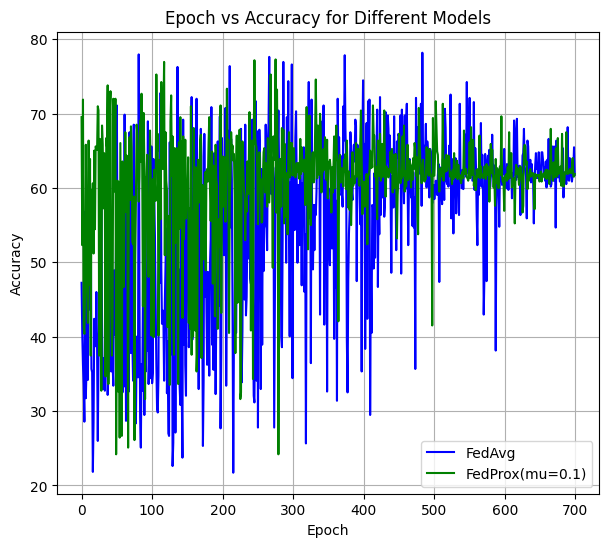

In [ ]:
# Plot accuracy for each model
epochs = list(range(0,700))
plt.figure(figsize=(7, 6))

# Model 1 (blue)
plt.plot(epochs, accuracy_fedavg, color='blue', label='FedAvg')

# Model 2 (green)
plt.plot(epochs, accuracy_fedprox, color='green', label='FedProx(mu=0.1)')

# Model 3 (red)
#plt.plot(epochs, accuracy_fedprox_mu, color='red', label='FedProx(mu=0.5)')

# Model 4 (orange)
#plt.plot(epochs, accuracy_qfedavg, color='orange', label='QFedAvg')

# Set plot title, labels, and legend
plt.title('Epoch vs Accuracy for Different Models')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()


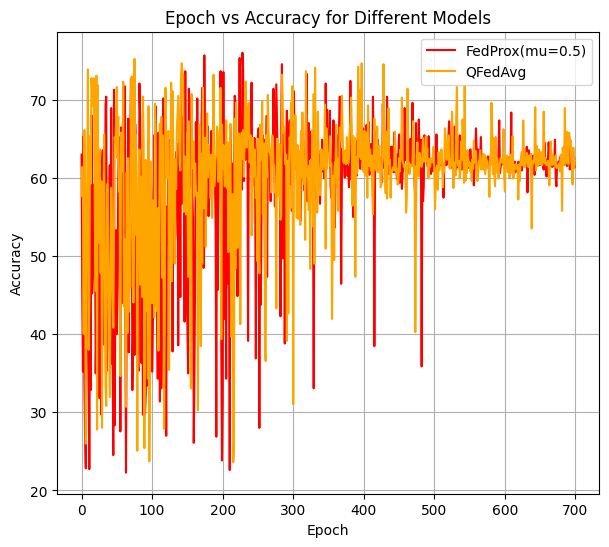

In [ ]:
# Plot accuracy for each model
epochs = list(range(0,700))
plt.figure(figsize=(7, 6))

# Model 1 (blue)
#plt.plot(epochs, accuracy_fedavg, color='blue', label='FedAvg')

# Model 2 (green)
#plt.plot(epochs, accuracy_fedprox, color='green', label='FedProx(mu=0.1)')

# Model 3 (red)
plt.plot(epochs, accuracy_fedprox_mu_1, color='red', label='FedProx(mu=0.5)')

# Model 4 (orange)
plt.plot(epochs, accuracy_qfedavg, color='orange', label='QFedAvg')

# Set plot title, labels, and legend
plt.title('Epoch vs Accuracy for Different Models')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

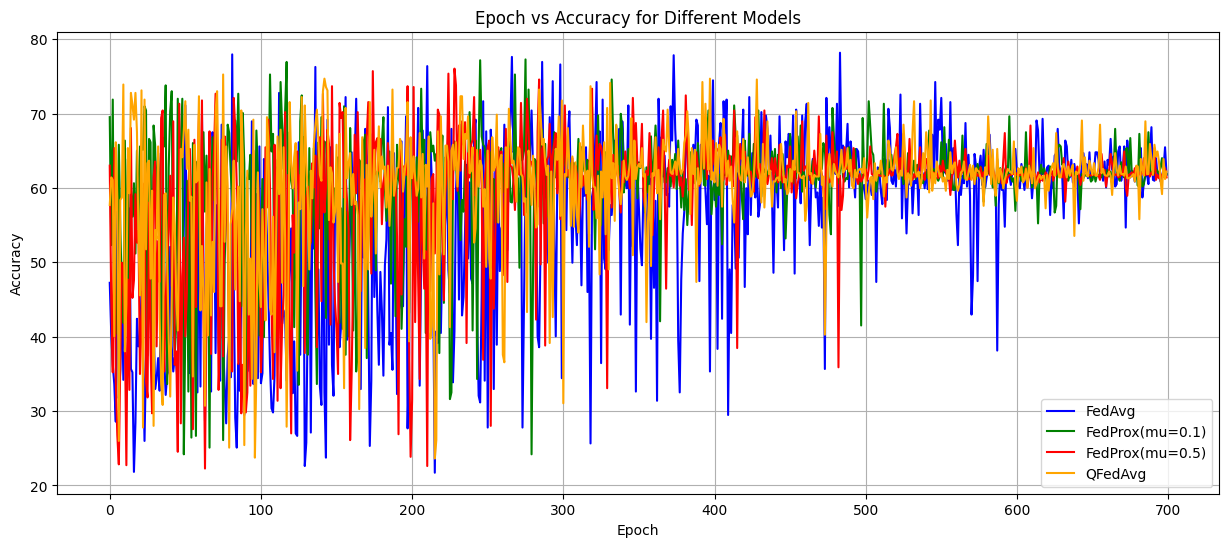

In [ ]:
# Plot accuracy for each model
epochs = list(range(0,700))
plt.figure(figsize=(15, 6))

# Model 1 (blue)
plt.plot(epochs, accuracy_fedavg, color='blue', label='FedAvg')

# Model 2 (green)
plt.plot(epochs, accuracy_fedprox, color='green', label='FedProx(mu=0.1)')

# Model 3 (red)
plt.plot(epochs, accuracy_fedprox_mu_1, color='red', label='FedProx(mu=0.5)')

# Model 4 (orange)
plt.plot(epochs, accuracy_qfedavg, color='orange', label='QFedAvg')

# Set plot title, labels, and legend
plt.title('Epoch vs Accuracy for Different Models')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()